In [163]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from fbprophet import Prophet


In [164]:
files = ['cleaned_files/mortgage.csv','cleaned_files/immigration.csv','cleaned_files/house_price.csv']
dfs=[pd.read_csv(f,parse_dates=True)for f in files]

In [165]:
dfs



[     Mortgage_Rate     date
 0             5.59  2005-02
 1             5.60  2005-03
 2             5.67  2005-04
 3             5.55  2005-05
 4             5.31  2005-06
 ..             ...      ...
 198           3.20  2021-08
 199           3.22  2021-09
 200           3.29  2021-10
 201           3.40  2021-11
 202           3.45  2021-12
 
 [203 rows x 2 columns],
       immigrants     date
 0    18812.66667  2005-01
 1    18812.66667  2005-02
 2    18812.66667  2005-03
 3    24823.66667  2005-04
 4    24823.66667  2005-05
 ..           ...      ...
 199  40970.33333  2021-08
 200  40970.33333  2021-09
 201  46063.33333  2021-10
 202  46063.33333  2021-11
 203  46063.33333  2021-12
 
 [204 rows x 2 columns],
      Composite_HPI_SA  Composite_Benchmark_SA     date
 0               100.0                  221100  2005-01
 1               100.6                  222500  2005-02
 2               101.4                  224200  2005-03
 3               102.2                  225900  20

In [166]:
price_data =pd.merge(pd.merge(dfs[0],dfs[1],on='date'),dfs[2],on='date')
df = price_data.drop('Composite_HPI_SA', axis=1)

In [167]:
df['date'] = pd.to_datetime(df['date'])
df

,Mortgage_Rate,date,immigrants,Composite_Benchmark_SA
0,5.59,2005-02-01,18812.66667,222500
1,5.60,2005-03-01,18812.66667,224200
2,5.67,2005-04-01,24823.66667,225900
3,5.55,2005-05-01,24823.66667,227400
4,5.31,2005-06-01,24823.66667,229600
...,...,...,...,...
198,3.20,2021-08-01,40970.33333,721900
199,3.22,2021-09-01,40970.33333,738200
200,3.29,2021-10-01,46063.33333,759500
201,3.40,2021-11-01,46063.33333,777000


In [168]:
df_train = df[0:150]
df_test = df[150:]
df_train

,Mortgage_Rate,date,immigrants,Composite_Benchmark_SA
0,5.59,2005-02-01,18812.66667,222500
1,5.60,2005-03-01,18812.66667,224200
2,5.67,2005-04-01,24823.66667,225900
3,5.55,2005-05-01,24823.66667,227400
4,5.31,2005-06-01,24823.66667,229600
...,...,...,...,...
145,3.66,2017-03-01,24279.66667,567300
146,3.62,2017-04-01,26004.00000,573700
147,3.59,2017-05-01,26004.00000,571700
148,3.60,2017-06-01,26004.00000,567200


In [169]:
df_train = df_train.rename(columns={'Composite_Benchmark_SA':'y','date':'ds'})
df_train

,Mortgage_Rate,ds,immigrants,y
0,5.59,2005-02-01,18812.66667,222500
1,5.60,2005-03-01,18812.66667,224200
2,5.67,2005-04-01,24823.66667,225900
3,5.55,2005-05-01,24823.66667,227400
4,5.31,2005-06-01,24823.66667,229600
...,...,...,...,...
145,3.66,2017-03-01,24279.66667,567300
146,3.62,2017-04-01,26004.00000,573700
147,3.59,2017-05-01,26004.00000,571700
148,3.60,2017-06-01,26004.00000,567200


In [170]:
df_train['y_orig'] = df_train['y'] # to save a copy of the original data
df_train['y'] = np.log(df_train['y'])

In [171]:
model_new = Prophet()
model_new.add_regressor('Mortgage_Rate')
model_new.add_regressor('immigrants')

In [172]:
model_new.fit(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [173]:
future_data= model_new.make_future_dataframe(periods=100, freq = 'M')
future_data

,ds
0,2005-02-01
1,2005-03-01
2,2005-04-01
3,2005-05-01
4,2005-06-01
...,...
245,2025-06-30
246,2025-07-31
247,2025-08-31
248,2025-09-30


In [174]:
df = df.append(df_test)
df = df.rename(columns={'Composite_Benchmark_SA':'y','date':'ds'})
future_data=df[['ds','Mortgage_Rate','immigrants']]

In [175]:
future_data.head()

,ds,Mortgage_Rate,immigrants
0,2005-02-01,5.59,18812.66667
1,2005-03-01,5.60,18812.66667
2,2005-04-01,5.67,24823.66667
3,2005-05-01,5.55,24823.66667
4,2005-06-01,5.31,24823.66667


In [176]:
forecast_data = model_new.predict(future_data)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
251,2021-10-01,13.841298,13.264366,14.414136
252,2021-11-01,13.853956,13.256080,14.450964
253,2021-11-01,13.853956,13.256981,14.447522
254,2021-12-01,13.867444,13.250087,14.478361
255,2021-12-01,13.867444,13.256609,14.482959


In [177]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Mortgage_Rate,Mortgage_Rate_lower,Mortgage_Rate_upper,additive_terms,...,immigrants,immigrants_lower,immigrants_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-02-01,12.293826,12.302702,12.317605,12.293826,12.293826,0.009415,0.009415,0.009415,0.016199,...,0.003129,0.003129,0.003129,0.003655,0.003655,0.003655,0.0,0.0,0.0,12.310025
1,2005-03-01,12.304716,12.310675,12.326164,12.304716,12.304716,0.009537,0.009537,0.009537,0.014103,...,0.003129,0.003129,0.003129,0.001437,0.001437,0.001437,0.0,0.0,0.0,12.318819
2,2005-04-01,12.316773,12.321023,12.336464,12.316773,12.316773,0.010396,0.010396,0.010396,0.012127,...,-0.003026,-0.003026,-0.003026,0.004756,0.004756,0.004756,0.0,0.0,0.0,12.328900
3,2005-05-01,12.328442,12.331035,12.345805,12.328442,12.328442,0.008924,0.008924,0.008924,0.009983,...,-0.003026,-0.003026,-0.003026,0.004085,0.004085,0.004085,0.0,0.0,0.0,12.338425
4,2005-06-01,12.340499,12.339209,12.354154,12.340499,12.340499,0.005979,0.005979,0.005979,0.005885,...,-0.003026,-0.003026,-0.003026,0.002932,0.002932,0.002932,0.0,0.0,0.0,12.346384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2021-10-01,13.887712,13.264366,14.414136,13.313770,14.459591,-0.018805,-0.018805,-0.018805,-0.046414,...,-0.024774,-0.024774,-0.024774,-0.002835,-0.002835,-0.002835,0.0,0.0,0.0,13.841298
252,2021-11-01,13.899647,13.256080,14.450964,13.301681,14.494953,-0.017455,-0.017455,-0.017455,-0.045691,...,-0.024774,-0.024774,-0.024774,-0.003462,-0.003462,-0.003462,0.0,0.0,0.0,13.853956
253,2021-11-01,13.899647,13.256981,14.447522,13.301681,14.494953,-0.017455,-0.017455,-0.017455,-0.045691,...,-0.024774,-0.024774,-0.024774,-0.003462,-0.003462,-0.003462,0.0,0.0,0.0,13.853956
254,2021-12-01,13.911197,13.250087,14.478361,13.296329,14.525639,-0.016842,-0.016842,-0.016842,-0.043753,...,-0.024774,-0.024774,-0.024774,-0.002137,-0.002137,-0.002137,0.0,0.0,0.0,13.867444


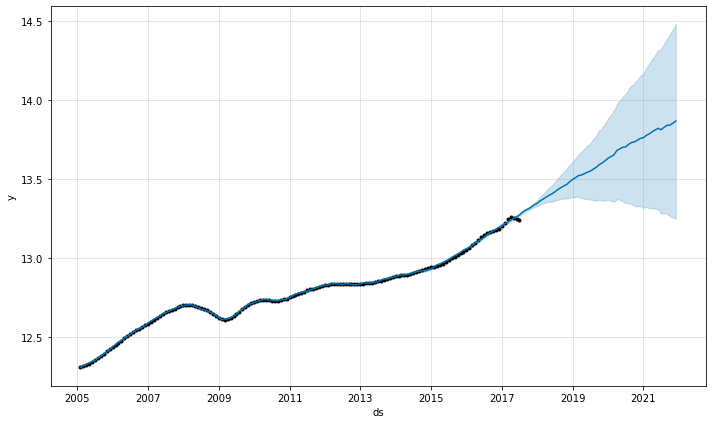

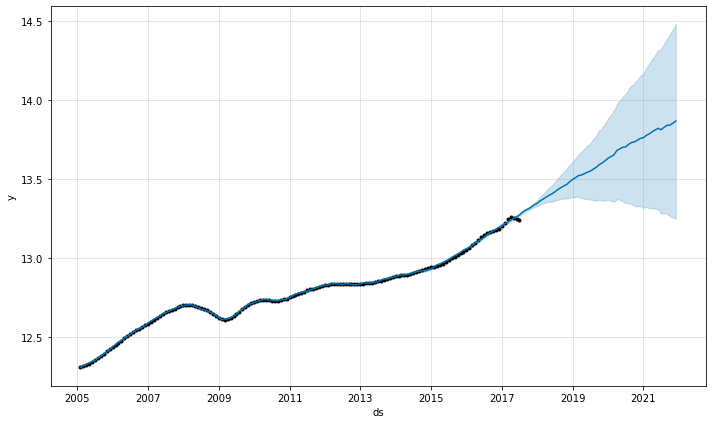

In [178]:
model_new.plot(forecast_data)

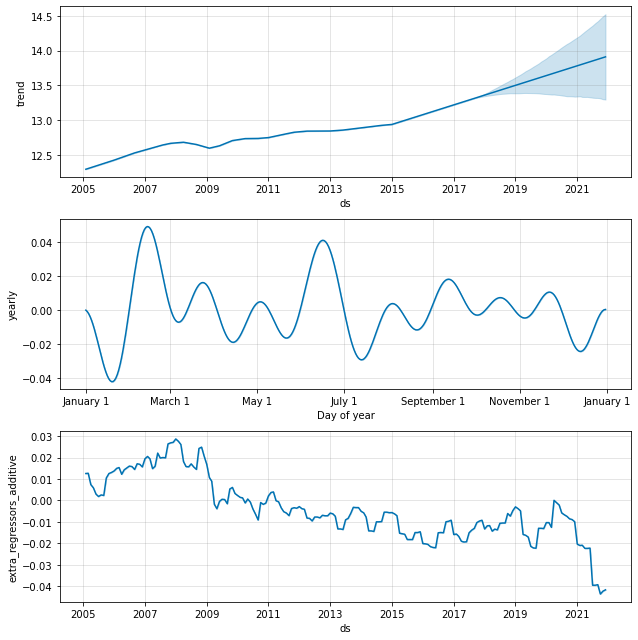

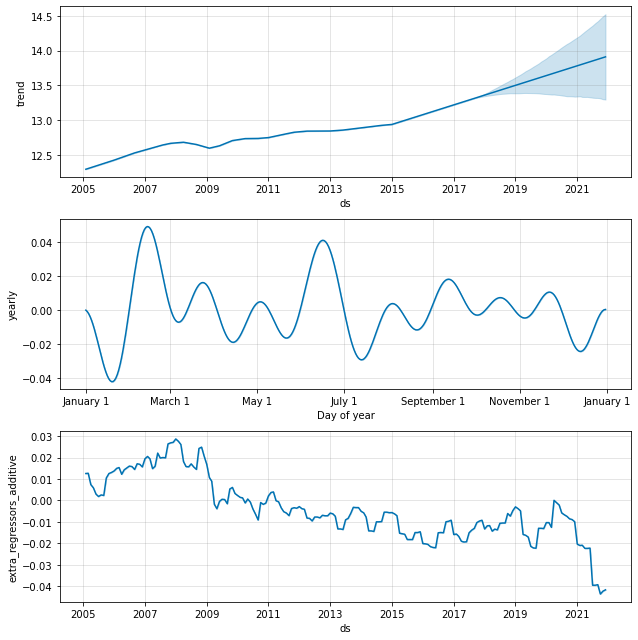

In [179]:
model_new.plot_components(forecast_data)

In [180]:
forecast_data_origi = forecast_data # make sure we save the original forecast data
forecast_data_origi['yhat'] = np.exp(forecast_data_origi['yhat'])
forecast_data_origi['yhat_lower'] = np.exp(forecast_data_origi['yhat_lower'])
forecast_data_origi['yhat_upper'] = np.exp(forecast_data_origi['yhat_upper'])

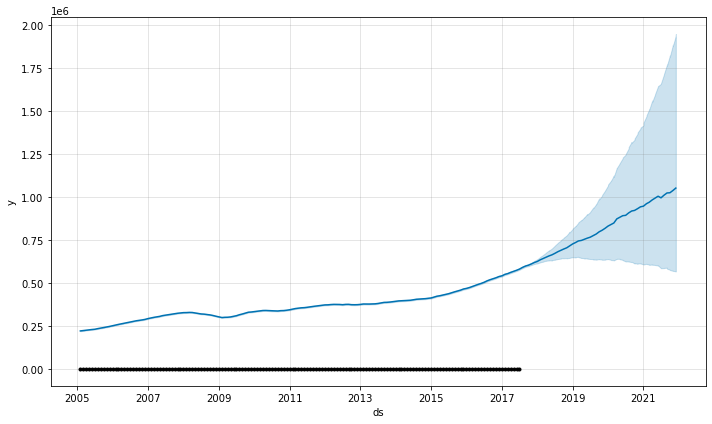

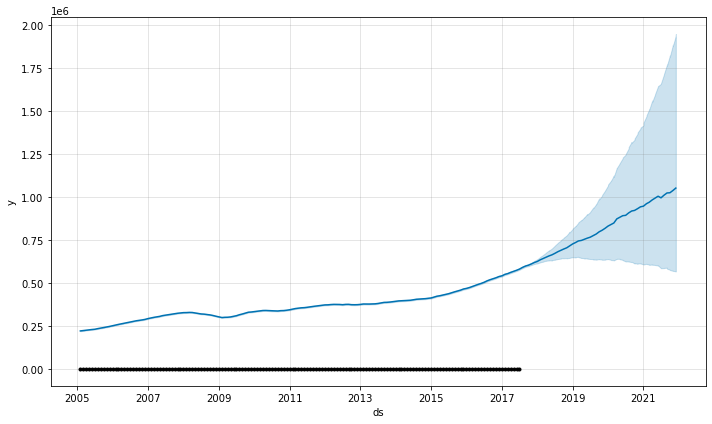

In [181]:
model_new.plot(forecast_data_origi)

In [182]:
df_train['y_log']=df_train['y']
df_train['y'] = df_train['y_orig']

In [183]:
df_train

,Mortgage_Rate,ds,immigrants,y,y_orig,y_log
0,5.59,2005-02-01,18812.66667,222500,222500,12.312682
1,5.60,2005-03-01,18812.66667,224200,224200,12.320294
2,5.67,2005-04-01,24823.66667,225900,225900,12.327848
3,5.55,2005-05-01,24823.66667,227400,227400,12.334466
4,5.31,2005-06-01,24823.66667,229600,229600,12.344094
...,...,...,...,...,...,...
145,3.66,2017-03-01,24279.66667,567300,567300,13.248644
146,3.62,2017-04-01,26004.00000,573700,573700,13.259862
147,3.59,2017-05-01,26004.00000,571700,571700,13.256370
148,3.60,2017-06-01,26004.00000,567200,567200,13.248467


In [184]:
final_df = pd.DataFrame(forecast_data_origi)
final_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Mortgage_Rate,Mortgage_Rate_lower,Mortgage_Rate_upper,additive_terms,...,immigrants,immigrants_lower,immigrants_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2005-02-01,12.293826,220290.340239,2.235981e+05,12.293826,12.293826,0.009415,0.009415,0.009415,0.016199,...,0.003129,0.003129,0.003129,0.003655,0.003655,0.003655,0.0,0.0,0.0,2.219094e+05
1,2005-03-01,12.304716,222053.861406,2.255199e+05,12.304716,12.304716,0.009537,0.009537,0.009537,0.014103,...,0.003129,0.003129,0.003129,0.001437,0.001437,0.001437,0.0,0.0,0.0,2.238697e+05
2,2005-04-01,12.316773,224363.634245,2.278548e+05,12.316773,12.316773,0.010396,0.010396,0.010396,0.012127,...,-0.003026,-0.003026,-0.003026,0.004756,0.004756,0.004756,0.0,0.0,0.0,2.261379e+05
3,2005-05-01,12.328442,226621.078889,2.299931e+05,12.328442,12.328442,0.008924,0.008924,0.008924,0.009983,...,-0.003026,-0.003026,-0.003026,0.004085,0.004085,0.004085,0.0,0.0,0.0,2.283020e+05
4,2005-06-01,12.340499,228481.216096,2.319215e+05,12.340499,12.340499,0.005979,0.005979,0.005979,0.005885,...,-0.003026,-0.003026,-0.003026,0.002932,0.002932,0.002932,0.0,0.0,0.0,2.301265e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2021-10-01,13.887712,576290.085682,1.819615e+06,13.313770,14.459591,-0.018805,-0.018805,-0.018805,-0.046414,...,-0.024774,-0.024774,-0.024774,-0.002835,-0.002835,-0.002835,0.0,0.0,0.0,1.026123e+06
252,2021-11-01,13.899647,571534.621435,1.887878e+06,13.301681,14.494953,-0.017455,-0.017455,-0.017455,-0.045691,...,-0.024774,-0.024774,-0.024774,-0.003462,-0.003462,-0.003462,0.0,0.0,0.0,1.039194e+06
253,2021-11-01,13.899647,572049.563777,1.881392e+06,13.301681,14.494953,-0.017455,-0.017455,-0.017455,-0.045691,...,-0.024774,-0.024774,-0.024774,-0.003462,-0.003462,-0.003462,0.0,0.0,0.0,1.039194e+06
254,2021-12-01,13.911197,568119.555752,1.940314e+06,13.296329,14.525639,-0.016842,-0.016842,-0.016842,-0.043753,...,-0.024774,-0.024774,-0.024774,-0.002137,-0.002137,-0.002137,0.0,0.0,0.0,1.053306e+06


In [185]:
import plotly.graph_objs as go
import plotly.offline as py
#plot predictied and actual line graph with X=dates, Y=outbound
actual_chart = go.Scatter(y=df_train['y_orig'], name='Actual')
predict_chart = go.Scatter(y=final_df['yhat'], name='Predicted')
predict_chart_upper = go.Scatter(y=final_df['yhat_upper'], name='Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df['yhat_lower'], name='Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'